In [1]:
import sys

#!conda install --yes --prefix {sys.prefix} pandas
#!conda install --yes --prefix {sys.prefix} pyodbc
#!conda install --yes --prefix {sys.prefix} numpy
#!conda install --yes --prefix {sys.prefix} matplotlib
#!conda install --yes --prefix {sys.prefix} nltk
#!conda install --yes --prefix {sys.prefix} keras

In [2]:
#all the imports used in the program

import pandas as pd 
import pyodbc
import numpy as np
import matplotlib.pyplot as plt
import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Dense, Bidirectional, LSTM, Convolution1D
from keras.layers import Input, Dropout, Activation, GRU, Flatten, GlobalMaxPool1D
from keras import initializers, regularizers, constraints, optimizers, layers
from sklearn.metrics import f1_score, confusion_matrix

Using TensorFlow backend.


In [3]:
#Grab data from a database

def getData(Server, Database, query):    
    
    #create a SQL connection based on the given server and database
    sql_conn = pyodbc.connect('DRIVER={SQL Server};'
                          'SERVER='+Server+';' 
                          'DATABASE='+Database+';' 
                          'Trusted_Connection=yes')
    
    #return the data from the given Query and SQL connection
    return pd.read_sql(query, sql_conn)

In [4]:
#establish my server and corresponding database to pull data from
server ='GESTALT-BT41Q'
database = 'MClinical'

#this query grabs sectionValues that are positive results
#Stores the result in a pandas DataFrame object called pos
query = "SELECT TOP (25000) 'POS' AS RESULT, ResultSection.sectionValue FROM ResultSection WHERE ResultSection.sectionValue <> ' ' AND ResultSection.sectionValue LIKE '%POSITIVE%' AND ResultSection.sectionValue NOT LIKE '%SHOULD NOT BE USED AS THE SOLE MEANS OF DETECTING %'"
pos = getData(server,database,query)

#this query grabs sectionValues that are negative results
#Stores the result in a pandas DataFrame object called neg
query ="SELECT TOP (25000) 'NEG' AS RESULT,ResultSection.sectionValue FROM ResultSection WHERE ResultSection.sectionValue <> ' ' AND ResultSection.sectionValue LIKE '%NEGATIVE%' AND ResultSection.sectionValue NOT LIKE '%POSITIVE%'"
neg = getData(server,database,query)



In [5]:
#concat the two dataframs pos and neg into one df
df = pd.concat([neg, pos]).reset_index(drop=True)
df['RESULT'] = df['RESULT'].map({'POS': 1, 'NEG': 0})



In [6]:
#removes words that have at one colon somewhere in the middle of two words
#and words that have two colons separated by three words. 

def removeColon(df):
    
    #Word array of words that i will later remove
    bagOfWords = []
    
    #a array of every word in the sectionValue on the given dataframe df
    wordList = df.sectionValue.str.split(expand=True).stack()
    
    for word in wordList:
        colonWord = re.search(r"\w+:\w+:\w+", word)
        if colonWord is None:
            colonWord = re.search(r"\w+:\w+", word)
        if colonWord is not None:
            if colonWord.group() not in bagOfWords:
                bagOfWords.append(colonWord.group())
    
    #return the updated dataframe sectionValue, only keeping words that are not contained in bagOfWords            
    return df['sectionValue'].apply(lambda x: ' '.join([word for word in x.split() if word not in (bagOfWords)]))

This method is more useful than it looks.

You pass in a pandas DataFrame and tweak it.

First, i create a empty list called bagOfWords

The next line seemes confusing but bassically what I am doing here is taking every word from the sectionValue column and creating a list in which each row only contains one word. This helps with the iterative process. I store the result of this into WordList(approx 1.4 million words)

Next, i iterate through every word in the wordList in a for loop.

let me explain how the search process works and what words i am looking to add to my bagOfWords
1. How does the search processWork?
    1. I use Regex(regular expression) to do my searching for me which is on a character by character basis
2. What kind of words am i looking for?
    1. \w+:\w+ and \w+:\w+:\w+
        1. \w searches for any character in the form [a-zA-Z0-9]
        2. \+ searches for the previous search condition until the end of the word. 
        3. : specifies that i want a colon 
        4. putting it all together 
            1. \w+:\w+ searches for a character in the form [a-zA-Z0-9] for any amount of characters in that form until it hits a colon : in which then it does the same \w+ until the end of the word.
            2. \w+:\w+:\w+ is the same as above just has two colons i hope you get the picture..
            
     
Since i am searching for two different types of words i need to search two different times for every word in wordList.

I search the word to see if it matches the pattern of having three words separated by 2 colons, this returns a match object which i store in colonWord.

if the word isnt found in the search it returns None, so i check if colonWord is None. If it is i search for the different type of word and store that searches result into colonWord.

After that process is done i finally check to see if either of my searches came back true(not None)

If they do i use colonWord.group() function to grab just the string(word) that it found.

Then Check the bagOfWords to see if the word i found is already in it. 

If the word is already in it I move onto the next word in the wordList.

if it is not, i simply  add it and move to the next word as well. 

Finally once i have scanned all words and created my bagOfWords that is a unique list i remove those words from the sectionValue column of the Data. 

what the last line in the funtion is doing is recreating my column sectionValue, but only keeping words that are NOT in bagOfWords.

Once that is done i return the new column of sectionValue. 

In [7]:
#here i wanted to remove punctuation from the column sectionValue in my pandas dataFrame
#i replace every character that matches with one of the following below with nothing.

def removePunctuation(df1):
    df1['sectionValue'] = df1['sectionValue'].str.replace(',', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('.', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('?', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('/', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('/', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('+', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('-', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('=', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('_', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace(')', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('(', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('*', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('&', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('^', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('%', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('$', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('#', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('@', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('!', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('>', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('<', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('[', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace(']', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('{', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('}', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('|', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace(':', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace(';', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('\'', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('\"', '')
    return df1
    

In [8]:
#adding my own custom stopWords
#super simple to add as you can see 
#modify as needed!

def addStopWords(stop):
    stop.append('-')
    stop.append('a')
    stop.append('b')
    stop.append('c')
    stop.append('d')
    stop.append('e')
    stop.append('f')
    stop.append('g')
    stop.append('h')
    stop.append('i')
    stop.append('j')
    stop.append('k')
    stop.append('l')
    stop.append('m')
    stop.append('n')
    stop.append('o')
    stop.append('p')
    stop.append('q')
    stop.append('r')
    stop.append('s')
    stop.append('t')
    stop.append('u')
    stop.append('v')
    stop.append('w')
    stop.append('x')
    stop.append('y')
    stop.append('z')
    stop.append('no')
    stop.append('see')
    stop.append('two')
    stop.append('0')
    stop.append('1')
    stop.append('2')
    stop.append('3')
    stop.append('4')
    stop.append('5')
    stop.append('6')
    stop.append('7')
    stop.append('8')
    stop.append('9')
    return stop

In [9]:
def removeStopWords(df):
    
    #stopWords are words that have relatively no meaning to any actual data
    #we dont want that here so lets remove them
    stop = stopwords.words('english')
    
    # add custom stopWords 
    stop = addStopWords(stop)
    
    # add this if you want to remove words that are smaller than size two
    # change the size to whatever you like 
    
    #df['sectionValue'] = df['sectionValue'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 2]))
    
    #returning the new sectionValue to the Datafram with words that are not in the StopWords
    return df['sectionValue'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


In [10]:
#change the case of all the words to lower case so there is no case sensitivity.
df['sectionValue'] = df['sectionValue'].str.lower()

#call the removeColon function to remove words with a colon or mulitple colons in the middle of the word
df['sectionValue'] = removeColon(df)

#call the removePuncuation code, notice how i did this after the removeColon function.
#it is important that we call this after the removeColon Function because this would remove colons
#from words we want to remove, and then the remove colon function would never find anything because there is no colons. 
df = removePunctuation(df)

#call the removeStopWords function to remove words that have no meaning.
df['sectionValue'] = removeStopWords(df)



In [11]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = " ".join(text)
    return text

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\csorensen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
df['sectionValue'] = df.sectionValue.apply(lambda x: clean_text(x))


In [13]:
df = df.sample(frac = 1).reset_index(drop = True)
print(df.head(20))

    RESULT                                       sectionValue
0        1  fna pancreatic head diagnosis pancreatic head ...
1        0                             hpv high risk negative
2        1  leave breast oclock right breast 10 oclock add...
3        0         negative intraepithelial lesion malignancy
4        1  case positive high risk hpv positive result cu...
5        0                             hpv high risk negative
6        1  receive four part label patient name receive f...
7        1  immunohistochemical andor situ hybridization s...
8        0                             hpv high risk negative
9        0  chlamydia trachomatis negative neisseria gonor...
10       1  case positive high risk hpv positive result cu...
11       1  case positive high risk hpv positive result cu...
12       1  candida albicans test perform use real time pc...
13       1  interpretation bone marrow aspiration flow cyt...
14       1  c44329 squamous cell carcinoma skin part face ...
15      

In [14]:
df.sectionValue.apply(lambda x: len(x.split(" "))).mean()

60.21784

In [16]:
max_features = 6000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df['sectionValue'])
list_tokenized_train = tokenizer.texts_to_sequences(df['sectionValue'])

maxlen = 65
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
y = df['RESULT']

embed_size = 128
model = Sequential()
model.add(Embedding(max_features, embed_size))
model.add(Bidirectional(LSTM(32, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 100
epochs = 3
history = model.fit(X_t,y,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)

model.save('pre_trained_model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         768000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 64)          41216     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                1300      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 810,537
Trainable params: 810,537
Non-trainable params: 0
_________________________________________________________________
Trai

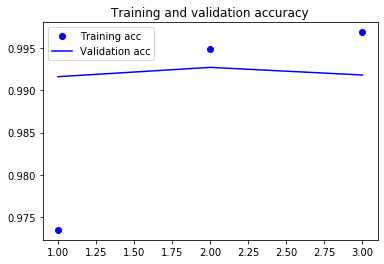

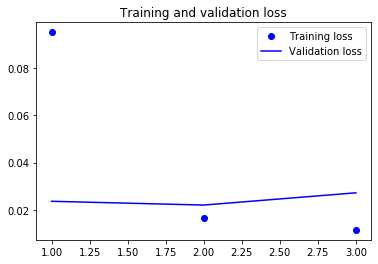

Validation Accuracy:  99.27000069618225
Training Accuracy:  99.68500030040741


In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

print('Validation Accuracy: ', val_acc[np.argmax(val_acc)] * 100)
print('Training Accuracy: ', acc[np.argmax(acc)] * 100)

In [47]:
#query = "SELECT TOP (25000) 'POS' AS RESULT, ResultSection.sectionValue FROM  ResultSection WHERE ResultSection.sectionValue <> ' ' AND ResultSection.sectionValue not LIKE '%NEGATIVE%' AND ResultSection.sectionValue LIKE '%POSITIVE%' AND (ResultSection.sectionCategory LIKE '%PATHOLOGIC%' OR ResultSection.sectionCategory LIKE '%RESULT%')"
query ="SELECT TOP (25000) 'POS' AS RESULT, ResultSection.sectionValue FROM ResultSection WHERE ( sectionValue LIKE '%HER2 oncogene protein overexpression: P%' OR sectionValue LIKE '%Estrogen receptor expression: P%' OR sectionValue LIKE'%Progesterone receptor expression: P%' OR sectionValue LIKE '%E-cadherin:  Positive%' OR sectionValue LIKE '%: POSIT%' OR sectionValue LIKE '%:  POSIT%' OR sectionValue LIKE '%:   POSIT%' ) --AND sectionCategory LIKE '%DIAGNO%'"
dftoc = getData(server,database,query)
dft  = dftoc.copy()
dft['RESULT'] = dft['RESULT'].map({'POS': 1, 'NEG': 0})

#change the case of all the words to lower case so there is no case sensitivity.
dft['sectionValue'] = dft['sectionValue'].str.lower()

#call the removeColon function to remove words with a colon or mulitple colons in the middle of the word
dft['sectionValue'] = removeColon(dft)

#call the removePuncuation code, notice how i did this after the removeColon function.
#it is important that we call this after the removeColon Function because this would remove colons
#from words we want to remove, and then the remove colon function would never find anything because there is no colons. 
dft = removePunctuation(dft)

#call the removeStopWords function to remove words that have no meaning.
dft['sectionValue'] = removeStopWords(dft)

dft['sectionValue'] = dft.sectionValue.apply(lambda x: clean_text(x))


In [48]:
y_test = dft["RESULT"]
list_sentences_test = dft["sectionValue"]
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)
prediction = model.predict(X_te)
y_pred = (prediction > 0.5)
print('F1-score: {0}'.format(f1_score(y_pred, y_test)))
print('Confusion matrix:')
print(confusion_matrix(y_pred, y_test))

print('\n\n\n')

##PRINTING OUT THE MISS CLASSED VALUES
temp = dftoc['sectionValue']
for i in range(1,len(y_pred)):
    if(y_pred[i] == False):
        print(i)
        print(temp[i])
        print('\n\n\n')
        

#PRINTING OUT A RANDOM POSITIVE RESULT
print('183')
print(temp[182])
        

F1-score: 0.9977695167286245
Confusion matrix:
[[   0    9]
 [   0 2013]]




551
 A. Left parotid gland, parotidectomy: Carcinoma of the parotid gland with the following features:     -  Specimen size:  7.7 x 4.6 x 3.2 cm.    -  Specimen laterality:  Left.    -  Tumor site: Left parotid gland.    -  Tumor focality:  Single focus.    -  Tumor size:  4.3 cm in greatest dimension.    -  Histologic type:  Squamous cell carcinoma.    -  Histologic grade:  Moderately-differentiated, keratinizing, grade    -  Microscopic tumor extension:  Tumor extends into dermis and peri-parotid fibroadipose tissue.    -  Margins:  Positive. Carcinoma is present at superior, posterior and anterior margins.  All other margins are negative for tumor.    -  Treatment effect:  Not applicable.    -  Lymph-vascular invasion:  Present.    -  Perineural invasion:  Present.    -  Additional findings:  The overlying epidermis is negative for tumor.    -  Lymph nodes:                    -  Number of lymph nodes exami

I TESTED THE MODEL PUTTING IN RESULTS I BELEIEVED WERE TO BE ONLY POSITIVE, THE RESULTS WAS THAT IT ONLY FOUND ONE RESULT THAT WAS NOT POSITIVE. I THINK THAT I NEED A BETTER WAY TO DETERMINE POSITIVE OR NEGATIVE FROM THE RESULTS BUT THIS IS A GREAT START! THESE RESULTS PASSED INTO FOR testing ARE PURPOSELY only POSITIVE TO TEST MY MODEL

In [44]:
#query = "SELECT TOP (25000) 'POS' AS RESULT, ResultSection.sectionValue FROM  ResultSection WHERE ResultSection.sectionValue <> ' ' AND ResultSection.sectionValue not LIKE '%NEGATIVE%' AND ResultSection.sectionValue LIKE '%POSITIVE%' AND (ResultSection.sectionCategory LIKE '%PATHOLOGIC%' OR ResultSection.sectionCategory LIKE '%RESULT%')"
query ="SELECT TOP (25000)  'NEG' AS RESULT, ResultSection.sectionValue  FROM ResultSection WHERE  ( (sectionValue LIKE '%HER2 oncogene protein overexpression: N%' AND sectionValue LIKE '%Estrogen receptor expression: N%' AND sectionValue LIKE'%Progesterone receptor expression: N%' AND sectionValue LIKE '%E-cadherin:  NEGATIVE%') OR (sectionValue LIKE '%: NEGA%' OR sectionValue LIKE '%:  NEGA%' OR sectionValue LIKE '%:   NEGA%' ) AND sectionCategory LIKE '%DIAGNO%' AND sectionValue NOT LIKE '%: POSIT%' AND sectionValue NOT LIKE '%:  POSIT%' AND sectionValue NOT LIKE '%:   POSIT%' AND sectionValue NOT LIKE'%POSITIVE%')"
dftoc = getData(server,database,query)
dft  = dftoc.copy()
dft['RESULT'] = dft['RESULT'].map({'POS': 1, 'NEG': 0})

#change the case of all the words to lower case so there is no case sensitivity.
dft['sectionValue'] = dft['sectionValue'].str.lower()

#call the removeColon function to remove words with a colon or mulitple colons in the middle of the word
dft['sectionValue'] = removeColon(dft)

#call the removePuncuation code, notice how i did this after the removeColon function.
#it is important that we call this after the removeColon Function because this would remove colons
#from words we want to remove, and then the remove colon function would never find anything because there is no colons. 
dft = removePunctuation(dft)

#call the removeStopWords function to remove words that have no meaning.
dft['sectionValue'] = removeStopWords(dft)

dft['sectionValue'] = dft.sectionValue.apply(lambda x: clean_text(x))


In [46]:
y_test = dft["RESULT"]
list_sentences_test = dft["sectionValue"]
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)
prediction = model.predict(X_te)
y_pred = (prediction > 0.5)
print('F1-score: {0}'.format(f1_score(y_pred, y_test)))
print('Confusion matrix:')
print(confusion_matrix(y_pred, y_test))

print('\n\n\n')

##PRINTING OUT THE MISS CLASSED VALUES
temp = dftoc['sectionValue']
for i in range(1,len(y_pred)):
    if(y_pred[i] == True):
        print(i)
        print(temp[i])
        print('\n\n\n')
        

#PRINTING OUT A RANDOM POSITIVE RESULT
print('183')
print(temp[182])
        

F1-score: 0.0
Confusion matrix:
[[447   0]
 [204   0]]




20
 A. Right breast central milk ducts, excision: - A minute (less than 1.0 mm) focus of ductal carcinoma in situ (DCIS). - Background of benign breast tissue and lactiferous ducts. See comment. B. Sentinel lymph node #1, right axilla, excision: - One lymph node, negative for metastatic carcinoma on multiple H&E level sections and by immunostaining for pancytokeratin AE1/AE3. C. Central lymph node #2, right axilla, excision: - One lymph node, negative for metastatic carcinoma on multi ple H&E level sections and by immunostaining for pancytokeratin AE1/AE3. D. Right breast, nipple-sparing mastectomy: Invasive carcinoma with the following features - Tumor Size: 0.2 cm in greatest dimension. Tumor Site: Right breast 4-6: 00. Tumor Focality: Single focus. Histologic Type: Invasive ductal carcinoma. See comment. Histologic Grade: Nottingham grade 2 of 3 (tubule score 3 of 3; nuclear score 2 of 3; mitotic rate less than 1 per 10 hpf,

In [25]:

print(temp[3599])
        

 HPV High Risk - POSITIVE 
